# 文本

## 字词嵌入

In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the Embedding layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [3]:
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

In [4]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.02995532, -0.02942706, -0.00700695,  0.03494493, -0.04972664],
       [-0.02281129, -0.02186141, -0.00720785,  0.01300696,  0.02450294],
       [ 0.04903224,  0.01025047,  0.04248634, -0.04208564,  0.04737928]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]])) # input (2, 3)
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The Text Classification with an RNN tutorial is a good next step.

### Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

In [7]:
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True
)

W0620 01:27:00.320754  7088 text_feature.py:61] TFDS datasets with text encoding are deprecated and will be removed in a future version. Instead, you should use the plain text version and tokenize the text using `tensorflow_text` (See: https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example)


Get the encoder (tfds.features.text.SubwordTextEncoder), and have a quick look at the vocabulary.

The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [20]:
encoder = info.features["text"].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the padded_batch method to standardize the lengths of the reviews.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [15]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy(), train_labels

(array([[ 857,  656,  229, ...,    0,    0,    0],
        [ 133, 1180,    2, ...,    0,    0,    0],
        [7676, 7961, 1803, ...,   16,   10,   17],
        ...,
        [  62,    9,    4, ...,    0,    0,    0],
        [1304,    4, 2743, ...,    0,    0,    0],
        [ 134,   82, 1133, ...,    0,    0,    0]], dtype=int64),
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int64)>)

Create a simple model

We will use the Keras Sequential API to define our model. In this case it is a "Continuous bag of words" style model.

+ Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

+ Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. Thi+ s allows the model to handle input of variable length, in the simplest way possible.

+ This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

+ The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [11]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


Compile and train the model

In [12]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=["accuracy"])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches,
    validation_steps=20
)

Epoch 1/10


    174/Unknown - 1s 1s/step - loss: 0.6931 - accuracy: 0.50 - 1s 743ms/step - loss: 0.6932 - accuracy: 0.550 - 2s 500ms/step - loss: 0.6932 - accuracy: 0.500 - 2s 379ms/step - loss: 0.6932 - accuracy: 0.550 - 2s 305ms/step - loss: 0.6932 - accuracy: 0.520 - 2s 256ms/step - loss: 0.6931 - accuracy: 0.533 - 2s 221ms/step - loss: 0.6931 - accuracy: 0.514 - 2s 195ms/step - loss: 0.6931 - accuracy: 0.512 - 2s 174ms/step - loss: 0.6932 - accuracy: 0.500 - 2s 158ms/step - loss: 0.6931 - accuracy: 0.500 - 2s 145ms/step - loss: 0.6931 - accuracy: 0.518 - 2s 133ms/step - loss: 0.6931 - accuracy: 0.500 - 2s 124ms/step - loss: 0.6931 - accuracy: 0.500 - 2s 115ms/step - loss: 0.6931 - accuracy: 0.492 - 2s 108ms/step - loss: 0.6931 - accuracy: 0.513 - 2s 102ms/step - loss: 0.6930 - accuracy: 0.518 - 2s 97ms/step - loss: 0.6930 - accuracy: 0.517 - 2s 92ms/step - loss: 0.6930 - accuracy: 0.51 - 2s 87ms/step - loss: 0.6930 - accuracy: 0.52 - 2s 84ms/step - loss: 0.6930 - accuracy: 0.52 - 2s 80ms/step 

    348/Unknown - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 18ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6927 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.50 - 3s 17ms/step - loss: 0.6926 - accuracy: 0.

    522/Unknown - 5s 14ms/step - loss: 0.6912 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6913 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6913 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6913 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6913 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6913 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6912 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6912 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6912 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6912 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 14ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6910 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6910 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6910 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6911 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6910 - accuracy: 0.50 - 5s 13ms/step - loss: 0.6910 - accuracy: 0.

    696/Unknown - 6s 12ms/step - loss: 0.6870 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6869 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6870 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6869 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6869 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6868 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6867 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6867 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6867 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6866 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6866 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6866 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6866 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6865 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6864 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6864 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6863 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6863 - accuracy: 0.49 - 6s 12ms/step - loss: 0.6863 - accuracy: 0.49 - 7s 12ms/step - loss: 0.6863 - accuracy: 0.50 - 7s 12ms/step - loss: 0.6863 - accuracy: 0.

    870/Unknown - 8s 12ms/step - loss: 0.6776 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6776 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6775 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6774 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6773 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6773 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6771 - accuracy: 0.50 - 8s 12ms/step - loss: 0.6769 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6767 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6766 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6766 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6765 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6764 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6763 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6763 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6763 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6761 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6760 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6759 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6757 - accuracy: 0.50 - 8s 11ms/step - loss: 0.6756 - accuracy: 0.

   1037/Unknown - 10s 11ms/step - loss: 0.6631 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6629 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6629 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6629 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6629 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6628 - accuracy: 0.523 - 10s 11ms/step - loss: 0.6625 - accuracy: 0.524 - 10s 11ms/step - loss: 0.6623 - accuracy: 0.524 - 10s 11ms/step - loss: 0.6622 - accuracy: 0.524 - 10s 11ms/step - loss: 0.6621 - accuracy: 0.525 - 10s 11ms/step - loss: 0.6619 - accuracy: 0.525 - 10s 11ms/step - loss: 0.6618 - accuracy: 0.525 - 10s 11ms/step - loss: 0.6617 - accuracy: 0.525 - 10s 11ms/step - loss: 0.6616 - accuracy: 0.526 - 10s 11ms/step - loss: 0.6615 - accuracy: 0.526 - 10s 11ms/step - loss: 0.6615 - accuracy: 0.526 - 10s 11ms/step - loss: 0.6613 - accuracy: 0.527 - 10s 11ms/step - loss: 0.6612 - accuracy: 0.527 - 10s 11ms/step - loss: 0.6612 - accuracy: 0.527 - 10s 11ms/step - loss: 0.6612 - accuracy: 0.527 - 10

   1204/Unknown - 11s 11ms/step - loss: 0.6445 - accuracy: 0.547 - 11s 11ms/step - loss: 0.6444 - accuracy: 0.547 - 11s 11ms/step - loss: 0.6443 - accuracy: 0.547 - 11s 11ms/step - loss: 0.6442 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6441 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6438 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6437 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6436 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6435 - accuracy: 0.548 - 11s 11ms/step - loss: 0.6433 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6430 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6429 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6428 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6426 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6425 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6423 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6423 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6421 - accuracy: 0.549 - 11s 11ms/step - loss: 0.6420 - accuracy: 0.550 - 11s 11ms/step - loss: 0.6419 - accuracy: 0.550 - 11

   1371/Unknown - 13s 11ms/step - loss: 0.6248 - accuracy: 0.573 - 13s 11ms/step - loss: 0.6246 - accuracy: 0.573 - 13s 11ms/step - loss: 0.6244 - accuracy: 0.573 - 13s 11ms/step - loss: 0.6242 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6241 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6238 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6237 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6236 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6235 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6233 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6232 - accuracy: 0.574 - 13s 11ms/step - loss: 0.6229 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6229 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6226 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6225 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6224 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6224 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6224 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6224 - accuracy: 0.575 - 13s 11ms/step - loss: 0.6223 - accuracy: 0.575 - 13

   1538/Unknown - 14s 10ms/step - loss: 0.6041 - accuracy: 0.597 - 14s 10ms/step - loss: 0.6040 - accuracy: 0.597 - 14s 10ms/step - loss: 0.6039 - accuracy: 0.597 - 14s 10ms/step - loss: 0.6037 - accuracy: 0.597 - 14s 10ms/step - loss: 0.6036 - accuracy: 0.597 - 14s 10ms/step - loss: 0.6034 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6033 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6032 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6030 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6029 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6028 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6028 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6027 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6025 - accuracy: 0.599 - 14s 10ms/step - loss: 0.6024 - accuracy: 0.598 - 14s 10ms/step - loss: 0.6023 - accuracy: 0.599 - 14s 10ms/step - loss: 0.6021 - accuracy: 0.599 - 14s 10ms/step - loss: 0.6022 - accuracy: 0.599 - 14s 10ms/step - loss: 0.6021 - accuracy: 0.599 - 14s 10ms/step - loss: 0.6018 - accuracy: 0.599 - 14

   1705/Unknown - 16s 10ms/step - loss: 0.5849 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5849 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5848 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5847 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5845 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5843 - accuracy: 0.619 - 16s 10ms/step - loss: 0.5842 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5841 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5840 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5839 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5838 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5836 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5836 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5835 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5834 - accuracy: 0.620 - 16s 10ms/step - loss: 0.5833 - accuracy: 0.621 - 16s 10ms/step - loss: 0.5832 - accuracy: 0.621 - 16s 10ms/step - loss: 0.5830 - accuracy: 0.621 - 16s 10ms/step - loss: 0.5829 - accuracy: 0.621 - 16s 10ms/step - loss: 0.5830 - accuracy: 0.621 - 16

   1872/Unknown - 17s 10ms/step - loss: 0.5676 - accuracy: 0.637 - 17s 10ms/step - loss: 0.5676 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5676 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5675 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5674 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5675 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5674 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5672 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5672 - accuracy: 0.637 - 18s 10ms/step - loss: 0.5670 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5670 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5669 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5667 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5666 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5665 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5665 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5663 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5662 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5661 - accuracy: 0.638 - 18s 10ms/step - loss: 0.5660 - accuracy: 0.638 - 18

   2039/Unknown - 19s 10ms/step - loss: 0.5518 - accuracy: 0.653 - 19s 10ms/step - loss: 0.5516 - accuracy: 0.653 - 19s 10ms/step - loss: 0.5515 - accuracy: 0.653 - 19s 10ms/step - loss: 0.5514 - accuracy: 0.653 - 19s 10ms/step - loss: 0.5513 - accuracy: 0.653 - 19s 10ms/step - loss: 0.5511 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5511 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5509 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5508 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5507 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5506 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5506 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5505 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5504 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5503 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5501 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5501 - accuracy: 0.654 - 19s 10ms/step - loss: 0.5500 - accuracy: 0.655 - 19s 10ms/step - loss: 0.5499 - accuracy: 0.655 - 19s 10ms/step - loss: 0.5496 - accuracy: 0.655 - 19

   2206/Unknown - 21s 10ms/step - loss: 0.5373 - accuracy: 0.668 - 21s 10ms/step - loss: 0.5371 - accuracy: 0.668 - 21s 10ms/step - loss: 0.5370 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5369 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5368 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5366 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5365 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5364 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5363 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5362 - accuracy: 0.669 - 21s 10ms/step - loss: 0.5361 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5360 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5359 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5358 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5360 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5358 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5358 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5359 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5358 - accuracy: 0.670 - 21s 10ms/step - loss: 0.5358 - accuracy: 0.670 - 21

   2373/Unknown - 22s 10ms/step - loss: 0.5244 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5244 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5244 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5243 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5242 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5241 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5240 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5239 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5238 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5237 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5236 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5235 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5233 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5232 - accuracy: 0.681 - 22s 10ms/step - loss: 0.5230 - accuracy: 0.682 - 22s 10ms/step - loss: 0.5229 - accuracy: 0.682 - 22s 10ms/step - loss: 0.5228 - accuracy: 0.682 - 22s 10ms/step - loss: 0.5227 - accuracy: 0.682 - 22s 10ms/step - loss: 0.5226 - accuracy: 0.682 - 22s 10ms/step - loss: 0.5227 - accuracy: 0.682 - 22

2500/2500 [==============================]5120 - accuracy: 0.692 - 23s 10ms/step - loss: 0.5119 - accuracy: 0.692 - 23s 10ms/step - loss: 0.5118 - accuracy: 0.692 - 23s 10ms/step - loss: 0.5117 - accuracy: 0.692 - 23s 10ms/step - loss: 0.5116 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5115 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5114 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5113 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5113 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5112 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5111 - accuracy: 0.693 - 23s 10ms/step - loss: 0.5110 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5110 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5109 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5109 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5109 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5108 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5106 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5105 - accuracy: 0.693 - 24s 10ms/step - loss: 0.5104 - accuracy: 0.694 - 24

2022/2500 [=======================>......] - ETA: 4:20 - loss: 0.3603 - accuracy: 0.90 - ETA: 32s - loss: 0.3085 - accuracy: 0.8917 - ETA: 21s - loss: 0.3142 - accuracy: 0.883 - ETA: 18s - loss: 0.3315 - accuracy: 0.871 - ETA: 17s - loss: 0.3320 - accuracy: 0.861 - ETA: 15s - loss: 0.3417 - accuracy: 0.866 - ETA: 15s - loss: 0.3392 - accuracy: 0.864 - ETA: 14s - loss: 0.3404 - accuracy: 0.861 - ETA: 13s - loss: 0.3449 - accuracy: 0.856 - ETA: 13s - loss: 0.3425 - accuracy: 0.855 - ETA: 12s - loss: 0.3389 - accuracy: 0.860 - ETA: 12s - loss: 0.3319 - accuracy: 0.862 - ETA: 12s - loss: 0.3268 - accuracy: 0.864 - ETA: 12s - loss: 0.3284 - accuracy: 0.867 - ETA: 12s - loss: 0.3289 - accuracy: 0.864 - ETA: 12s - loss: 0.3336 - accuracy: 0.860 - ETA: 11s - loss: 0.3339 - accuracy: 0.859 - ETA: 11s - loss: 0.3305 - accuracy: 0.862 - ETA: 11s - loss: 0.3250 - accuracy: 0.864 - ETA: 11s - loss: 0.3242 - accuracy: 0.863 - ETA: 11s - loss: 0.3255 - accuracy: 0.862 - ETA: 11s - loss: 0.3247 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.2853 - accuracy: 0.88 - ETA: 2s - loss: 0.2855 - accuracy: 0.88 - ETA: 2s - loss: 0.2853 - accuracy: 0.88 - ETA: 2s - loss: 0.2854 - accuracy: 0.88 - ETA: 2s - loss: 0.2851 - accuracy: 0.88 - ETA: 2s - loss: 0.2853 - accuracy: 0.88 - ETA: 2s - loss: 0.2850 - accuracy: 0.88 - ETA: 2s - loss: 0.2847 - accuracy: 0.88 - ETA: 1s - loss: 0.2844 - accuracy: 0.88 - ETA: 1s - loss: 0.2843 - accuracy: 0.88 - ETA: 1s - loss: 0.2840 - accuracy: 0.88 - ETA: 1s - loss: 0.2844 - accuracy: 0.88 - ETA: 1s - loss: 0.2845 - accuracy: 0.88 - ETA: 1s - loss: 0.2844 - accuracy: 0.88 - ETA: 1s - loss: 0.2843 - accuracy: 0.88 - ETA: 1s - loss: 0.2840 - accuracy: 0.88 - ETA: 1s - loss: 0.2835 - accuracy: 0.88 - ETA: 1s - loss: 0.2834 - accuracy: 0.88 - ETA: 1s - loss: 0.2835 - accuracy: 0.88 - ETA: 1s - loss: 0.2839 - accuracy: 0.88 - ETA: 1s - loss: 0.2834 - accuracy: 0.88 - ETA: 1s - loss: 0.2834 - accuracy: 0.88 - ETA: 1s - loss: 0.2831 - accura

2114/2500 [========================>.....] - ETA: 4:38 - loss: 0.1764 - accuracy: 0.90 - ETA: 50s - loss: 0.2793 - accuracy: 0.8750 - ETA: 27s - loss: 0.2797 - accuracy: 0.889 - ETA: 20s - loss: 0.2589 - accuracy: 0.893 - ETA: 18s - loss: 0.2521 - accuracy: 0.887 - ETA: 16s - loss: 0.2550 - accuracy: 0.890 - ETA: 16s - loss: 0.2554 - accuracy: 0.896 - ETA: 15s - loss: 0.2429 - accuracy: 0.906 - ETA: 14s - loss: 0.2406 - accuracy: 0.905 - ETA: 13s - loss: 0.2486 - accuracy: 0.902 - ETA: 13s - loss: 0.2539 - accuracy: 0.896 - ETA: 13s - loss: 0.2504 - accuracy: 0.897 - ETA: 13s - loss: 0.2484 - accuracy: 0.900 - ETA: 12s - loss: 0.2512 - accuracy: 0.900 - ETA: 12s - loss: 0.2547 - accuracy: 0.897 - ETA: 12s - loss: 0.2554 - accuracy: 0.897 - ETA: 12s - loss: 0.2576 - accuracy: 0.895 - ETA: 12s - loss: 0.2615 - accuracy: 0.894 - ETA: 11s - loss: 0.2568 - accuracy: 0.896 - ETA: 11s - loss: 0.2582 - accuracy: 0.895 - ETA: 11s - loss: 0.2600 - accuracy: 0.896 - ETA: 11s - loss: 0.2606 - accu

2500/2500 [==============================] - ETA: 1s - loss: 0.2279 - accuracy: 0.91 - ETA: 1s - loss: 0.2277 - accuracy: 0.91 - ETA: 1s - loss: 0.2276 - accuracy: 0.91 - ETA: 1s - loss: 0.2276 - accuracy: 0.91 - ETA: 1s - loss: 0.2273 - accuracy: 0.91 - ETA: 1s - loss: 0.2281 - accuracy: 0.91 - ETA: 1s - loss: 0.2278 - accuracy: 0.91 - ETA: 1s - loss: 0.2279 - accuracy: 0.91 - ETA: 1s - loss: 0.2279 - accuracy: 0.91 - ETA: 1s - loss: 0.2279 - accuracy: 0.91 - ETA: 1s - loss: 0.2276 - accuracy: 0.91 - ETA: 1s - loss: 0.2272 - accuracy: 0.91 - ETA: 1s - loss: 0.2270 - accuracy: 0.91 - ETA: 1s - loss: 0.2267 - accuracy: 0.91 - ETA: 1s - loss: 0.2266 - accuracy: 0.91 - ETA: 0s - loss: 0.2265 - accuracy: 0.91 - ETA: 0s - loss: 0.2266 - accuracy: 0.91 - ETA: 0s - loss: 0.2263 - accuracy: 0.91 - ETA: 0s - loss: 0.2263 - accuracy: 0.91 - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - ETA: 0s - loss: 0.2257 - accuracy: 0.91 - ETA: 0s - loss: 0.2261 - accuracy: 0.91 - ETA: 0s - loss: 0.2266 - accura

2038/2500 [=======================>......] - ETA: 4:30 - loss: 0.0762 - accuracy: 1.00 - ETA: 33s - loss: 0.2921 - accuracy: 0.9083 - ETA: 21s - loss: 0.2939 - accuracy: 0.892 - ETA: 20s - loss: 0.2810 - accuracy: 0.893 - ETA: 18s - loss: 0.2777 - accuracy: 0.881 - ETA: 16s - loss: 0.2603 - accuracy: 0.900 - ETA: 16s - loss: 0.2563 - accuracy: 0.903 - ETA: 15s - loss: 0.2537 - accuracy: 0.900 - ETA: 15s - loss: 0.2463 - accuracy: 0.903 - ETA: 15s - loss: 0.2458 - accuracy: 0.901 - ETA: 14s - loss: 0.2473 - accuracy: 0.898 - ETA: 14s - loss: 0.2494 - accuracy: 0.900 - ETA: 14s - loss: 0.2457 - accuracy: 0.904 - ETA: 14s - loss: 0.2444 - accuracy: 0.906 - ETA: 13s - loss: 0.2389 - accuracy: 0.908 - ETA: 13s - loss: 0.2371 - accuracy: 0.911 - ETA: 13s - loss: 0.2338 - accuracy: 0.912 - ETA: 13s - loss: 0.2337 - accuracy: 0.910 - ETA: 13s - loss: 0.2313 - accuracy: 0.910 - ETA: 13s - loss: 0.2283 - accuracy: 0.912 - ETA: 13s - loss: 0.2288 - accuracy: 0.912 - ETA: 13s - loss: 0.2253 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1961 - accuracy: 0.92 - ETA: 2s - loss: 0.1963 - accuracy: 0.92 - ETA: 2s - loss: 0.1962 - accuracy: 0.92 - ETA: 2s - loss: 0.1962 - accuracy: 0.92 - ETA: 1s - loss: 0.1964 - accuracy: 0.92 - ETA: 1s - loss: 0.1965 - accuracy: 0.92 - ETA: 1s - loss: 0.1967 - accuracy: 0.92 - ETA: 1s - loss: 0.1967 - accuracy: 0.92 - ETA: 1s - loss: 0.1967 - accuracy: 0.92 - ETA: 1s - loss: 0.1967 - accuracy: 0.92 - ETA: 1s - loss: 0.1963 - accuracy: 0.92 - ETA: 1s - loss: 0.1961 - accuracy: 0.92 - ETA: 1s - loss: 0.1963 - accuracy: 0.92 - ETA: 1s - loss: 0.1959 - accuracy: 0.92 - ETA: 1s - loss: 0.1960 - accuracy: 0.92 - ETA: 1s - loss: 0.1958 - accuracy: 0.92 - ETA: 1s - loss: 0.1957 - accuracy: 0.92 - ETA: 1s - loss: 0.1958 - accuracy: 0.92 - ETA: 1s - loss: 0.1953 - accuracy: 0.92 - ETA: 1s - loss: 0.1954 - accuracy: 0.92 - ETA: 1s - loss: 0.1951 - accuracy: 0.92 - ETA: 1s - loss: 0.1952 - accuracy: 0.92 - ETA: 1s - loss: 0.1953 - accura

2066/2500 [=======================>......] - ETA: 5:30 - loss: 0.5836 - accuracy: 0.80 - ETA: 38s - loss: 0.2563 - accuracy: 0.9000 - ETA: 24s - loss: 0.2208 - accuracy: 0.904 - ETA: 20s - loss: 0.2092 - accuracy: 0.911 - ETA: 18s - loss: 0.2132 - accuracy: 0.910 - ETA: 17s - loss: 0.2227 - accuracy: 0.910 - ETA: 16s - loss: 0.2034 - accuracy: 0.921 - ETA: 15s - loss: 0.2110 - accuracy: 0.914 - ETA: 15s - loss: 0.2084 - accuracy: 0.914 - ETA: 14s - loss: 0.2053 - accuracy: 0.916 - ETA: 14s - loss: 0.2125 - accuracy: 0.913 - ETA: 14s - loss: 0.2092 - accuracy: 0.917 - ETA: 14s - loss: 0.2112 - accuracy: 0.916 - ETA: 13s - loss: 0.2119 - accuracy: 0.915 - ETA: 13s - loss: 0.2034 - accuracy: 0.919 - ETA: 13s - loss: 0.1999 - accuracy: 0.920 - ETA: 13s - loss: 0.1987 - accuracy: 0.919 - ETA: 13s - loss: 0.2005 - accuracy: 0.920 - ETA: 12s - loss: 0.1980 - accuracy: 0.920 - ETA: 12s - loss: 0.2017 - accuracy: 0.920 - ETA: 12s - loss: 0.1991 - accuracy: 0.921 - ETA: 12s - loss: 0.1979 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1762 - accuracy: 0.93 - ETA: 2s - loss: 0.1770 - accuracy: 0.93 - ETA: 1s - loss: 0.1774 - accuracy: 0.93 - ETA: 1s - loss: 0.1777 - accuracy: 0.93 - ETA: 1s - loss: 0.1778 - accuracy: 0.93 - ETA: 1s - loss: 0.1774 - accuracy: 0.93 - ETA: 1s - loss: 0.1775 - accuracy: 0.93 - ETA: 1s - loss: 0.1776 - accuracy: 0.93 - ETA: 1s - loss: 0.1773 - accuracy: 0.93 - ETA: 1s - loss: 0.1771 - accuracy: 0.93 - ETA: 1s - loss: 0.1767 - accuracy: 0.93 - ETA: 1s - loss: 0.1765 - accuracy: 0.93 - ETA: 1s - loss: 0.1764 - accuracy: 0.93 - ETA: 1s - loss: 0.1764 - accuracy: 0.93 - ETA: 1s - loss: 0.1762 - accuracy: 0.93 - ETA: 1s - loss: 0.1763 - accuracy: 0.93 - ETA: 1s - loss: 0.1759 - accuracy: 0.93 - ETA: 1s - loss: 0.1760 - accuracy: 0.93 - ETA: 1s - loss: 0.1761 - accuracy: 0.93 - ETA: 1s - loss: 0.1760 - accuracy: 0.93 - ETA: 1s - loss: 0.1757 - accuracy: 0.93 - ETA: 0s - loss: 0.1761 - accuracy: 0.93 - ETA: 0s - loss: 0.1760 - accura

1992/2500 [======================>.......] - ETA: 5:28 - loss: 0.3865 - accuracy: 0.90 - ETA: 32s - loss: 0.2298 - accuracy: 0.9357 - ETA: 23s - loss: 0.1986 - accuracy: 0.916 - ETA: 17s - loss: 0.1814 - accuracy: 0.925 - ETA: 16s - loss: 0.1723 - accuracy: 0.934 - ETA: 15s - loss: 0.1647 - accuracy: 0.940 - ETA: 15s - loss: 0.1630 - accuracy: 0.942 - ETA: 14s - loss: 0.1757 - accuracy: 0.934 - ETA: 13s - loss: 0.1683 - accuracy: 0.938 - ETA: 13s - loss: 0.1727 - accuracy: 0.936 - ETA: 13s - loss: 0.1689 - accuracy: 0.934 - ETA: 13s - loss: 0.1704 - accuracy: 0.935 - ETA: 13s - loss: 0.1714 - accuracy: 0.935 - ETA: 13s - loss: 0.1761 - accuracy: 0.934 - ETA: 13s - loss: 0.1768 - accuracy: 0.934 - ETA: 12s - loss: 0.1736 - accuracy: 0.934 - ETA: 12s - loss: 0.1710 - accuracy: 0.935 - ETA: 12s - loss: 0.1695 - accuracy: 0.936 - ETA: 12s - loss: 0.1710 - accuracy: 0.935 - ETA: 12s - loss: 0.1759 - accuracy: 0.934 - ETA: 12s - loss: 0.1743 - accuracy: 0.934 - ETA: 12s - loss: 0.1783 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1573 - accuracy: 0.94 - ETA: 2s - loss: 0.1570 - accuracy: 0.94 - ETA: 2s - loss: 0.1567 - accuracy: 0.94 - ETA: 2s - loss: 0.1570 - accuracy: 0.94 - ETA: 2s - loss: 0.1568 - accuracy: 0.94 - ETA: 2s - loss: 0.1568 - accuracy: 0.94 - ETA: 2s - loss: 0.1569 - accuracy: 0.94 - ETA: 2s - loss: 0.1565 - accuracy: 0.94 - ETA: 2s - loss: 0.1565 - accuracy: 0.94 - ETA: 2s - loss: 0.1564 - accuracy: 0.94 - ETA: 1s - loss: 0.1564 - accuracy: 0.94 - ETA: 1s - loss: 0.1566 - accuracy: 0.94 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1565 - accuracy: 0.94 - ETA: 1s - loss: 0.1570 - accuracy: 0.94 - ETA: 1s - loss: 0.1567 - accuracy: 0.94 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1566 - accuracy: 0.94 - ETA: 1s - loss: 0.1566 - accuracy: 0.94 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1567 - accura

1959/2500 [======================>.......] - ETA: 4:38 - loss: 0.2280 - accuracy: 0.90 - ETA: 31s - loss: 0.1955 - accuracy: 0.9077 - ETA: 20s - loss: 0.1429 - accuracy: 0.942 - ETA: 17s - loss: 0.1593 - accuracy: 0.929 - ETA: 16s - loss: 0.1496 - accuracy: 0.936 - ETA: 15s - loss: 0.1446 - accuracy: 0.943 - ETA: 14s - loss: 0.1441 - accuracy: 0.942 - ETA: 14s - loss: 0.1605 - accuracy: 0.936 - ETA: 14s - loss: 0.1611 - accuracy: 0.938 - ETA: 13s - loss: 0.1555 - accuracy: 0.939 - ETA: 13s - loss: 0.1482 - accuracy: 0.943 - ETA: 12s - loss: 0.1506 - accuracy: 0.942 - ETA: 12s - loss: 0.1534 - accuracy: 0.943 - ETA: 12s - loss: 0.1496 - accuracy: 0.944 - ETA: 12s - loss: 0.1537 - accuracy: 0.944 - ETA: 12s - loss: 0.1523 - accuracy: 0.944 - ETA: 12s - loss: 0.1504 - accuracy: 0.945 - ETA: 12s - loss: 0.1477 - accuracy: 0.946 - ETA: 12s - loss: 0.1504 - accuracy: 0.945 - ETA: 12s - loss: 0.1502 - accuracy: 0.944 - ETA: 11s - loss: 0.1477 - accuracy: 0.946 - ETA: 11s - loss: 0.1470 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1404 - accuracy: 0.94 - ETA: 2s - loss: 0.1401 - accuracy: 0.94 - ETA: 2s - loss: 0.1398 - accuracy: 0.94 - ETA: 2s - loss: 0.1395 - accuracy: 0.94 - ETA: 2s - loss: 0.1395 - accuracy: 0.94 - ETA: 2s - loss: 0.1395 - accuracy: 0.94 - ETA: 2s - loss: 0.1397 - accuracy: 0.94 - ETA: 2s - loss: 0.1396 - accuracy: 0.94 - ETA: 2s - loss: 0.1394 - accuracy: 0.94 - ETA: 2s - loss: 0.1394 - accuracy: 0.94 - ETA: 2s - loss: 0.1396 - accuracy: 0.94 - ETA: 2s - loss: 0.1399 - accuracy: 0.94 - ETA: 2s - loss: 0.1397 - accuracy: 0.94 - ETA: 2s - loss: 0.1401 - accuracy: 0.94 - ETA: 1s - loss: 0.1407 - accuracy: 0.94 - ETA: 1s - loss: 0.1407 - accuracy: 0.94 - ETA: 1s - loss: 0.1409 - accuracy: 0.94 - ETA: 1s - loss: 0.1407 - accuracy: 0.94 - ETA: 1s - loss: 0.1406 - accuracy: 0.94 - ETA: 1s - loss: 0.1406 - accuracy: 0.94 - ETA: 1s - loss: 0.1409 - accuracy: 0.94 - ETA: 1s - loss: 0.1409 - accuracy: 0.94 - ETA: 1s - loss: 0.1411 - accura

1997/2500 [======================>.......] - ETA: 4:25 - loss: 0.0321 - accuracy: 1.00 - ETA: 30s - loss: 0.1626 - accuracy: 0.9385 - ETA: 25s - loss: 0.1816 - accuracy: 0.942 - ETA: 19s - loss: 0.1829 - accuracy: 0.952 - ETA: 18s - loss: 0.1658 - accuracy: 0.952 - ETA: 17s - loss: 0.1542 - accuracy: 0.953 - ETA: 16s - loss: 0.1560 - accuracy: 0.949 - ETA: 15s - loss: 0.1469 - accuracy: 0.955 - ETA: 14s - loss: 0.1554 - accuracy: 0.948 - ETA: 14s - loss: 0.1615 - accuracy: 0.944 - ETA: 14s - loss: 0.1672 - accuracy: 0.940 - ETA: 13s - loss: 0.1641 - accuracy: 0.939 - ETA: 13s - loss: 0.1615 - accuracy: 0.940 - ETA: 13s - loss: 0.1561 - accuracy: 0.943 - ETA: 13s - loss: 0.1545 - accuracy: 0.945 - ETA: 13s - loss: 0.1519 - accuracy: 0.945 - ETA: 12s - loss: 0.1500 - accuracy: 0.944 - ETA: 12s - loss: 0.1482 - accuracy: 0.946 - ETA: 12s - loss: 0.1506 - accuracy: 0.944 - ETA: 12s - loss: 0.1511 - accuracy: 0.944 - ETA: 12s - loss: 0.1494 - accuracy: 0.945 - ETA: 12s - loss: 0.1490 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1290 - accuracy: 0.95 - ETA: 2s - loss: 0.1290 - accuracy: 0.95 - ETA: 2s - loss: 0.1295 - accuracy: 0.95 - ETA: 2s - loss: 0.1291 - accuracy: 0.95 - ETA: 2s - loss: 0.1290 - accuracy: 0.95 - ETA: 2s - loss: 0.1289 - accuracy: 0.95 - ETA: 2s - loss: 0.1288 - accuracy: 0.95 - ETA: 2s - loss: 0.1295 - accuracy: 0.95 - ETA: 2s - loss: 0.1293 - accuracy: 0.95 - ETA: 2s - loss: 0.1294 - accuracy: 0.95 - ETA: 2s - loss: 0.1292 - accuracy: 0.95 - ETA: 1s - loss: 0.1291 - accuracy: 0.95 - ETA: 1s - loss: 0.1289 - accuracy: 0.95 - ETA: 1s - loss: 0.1287 - accuracy: 0.95 - ETA: 1s - loss: 0.1285 - accuracy: 0.95 - ETA: 1s - loss: 0.1282 - accuracy: 0.95 - ETA: 1s - loss: 0.1282 - accuracy: 0.95 - ETA: 1s - loss: 0.1280 - accuracy: 0.95 - ETA: 1s - loss: 0.1276 - accuracy: 0.95 - ETA: 1s - loss: 0.1275 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1270 - accuracy: 0.95 - ETA: 1s - loss: 0.1267 - accura

2030/2500 [=======================>......] - ETA: 5:33 - loss: 0.1154 - accuracy: 0.90 - ETA: 32s - loss: 0.0938 - accuracy: 0.9643 - ETA: 23s - loss: 0.1039 - accuracy: 0.956 - ETA: 19s - loss: 0.0992 - accuracy: 0.958 - ETA: 17s - loss: 0.1124 - accuracy: 0.956 - ETA: 17s - loss: 0.1181 - accuracy: 0.952 - ETA: 16s - loss: 0.1291 - accuracy: 0.952 - ETA: 15s - loss: 0.1231 - accuracy: 0.950 - ETA: 14s - loss: 0.1280 - accuracy: 0.951 - ETA: 14s - loss: 0.1208 - accuracy: 0.954 - ETA: 13s - loss: 0.1289 - accuracy: 0.950 - ETA: 13s - loss: 0.1237 - accuracy: 0.953 - ETA: 13s - loss: 0.1305 - accuracy: 0.953 - ETA: 13s - loss: 0.1336 - accuracy: 0.952 - ETA: 13s - loss: 0.1333 - accuracy: 0.951 - ETA: 12s - loss: 0.1334 - accuracy: 0.952 - ETA: 12s - loss: 0.1352 - accuracy: 0.952 - ETA: 12s - loss: 0.1311 - accuracy: 0.954 - ETA: 12s - loss: 0.1300 - accuracy: 0.953 - ETA: 12s - loss: 0.1328 - accuracy: 0.952 - ETA: 12s - loss: 0.1319 - accuracy: 0.952 - ETA: 12s - loss: 0.1293 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1176 - accuracy: 0.95 - ETA: 2s - loss: 0.1176 - accuracy: 0.95 - ETA: 2s - loss: 0.1175 - accuracy: 0.95 - ETA: 2s - loss: 0.1173 - accuracy: 0.95 - ETA: 2s - loss: 0.1174 - accuracy: 0.95 - ETA: 2s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1170 - accuracy: 0.95 - ETA: 1s - loss: 0.1170 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accura

2056/2500 [=======================>......] - ETA: 4:48 - loss: 0.3431 - accuracy: 0.70 - ETA: 32s - loss: 0.1358 - accuracy: 0.9385 - ETA: 20s - loss: 0.1285 - accuracy: 0.930 - ETA: 18s - loss: 0.1207 - accuracy: 0.936 - ETA: 16s - loss: 0.1221 - accuracy: 0.947 - ETA: 15s - loss: 0.1238 - accuracy: 0.950 - ETA: 14s - loss: 0.1221 - accuracy: 0.949 - ETA: 14s - loss: 0.1168 - accuracy: 0.952 - ETA: 14s - loss: 0.1194 - accuracy: 0.955 - ETA: 13s - loss: 0.1196 - accuracy: 0.957 - ETA: 13s - loss: 0.1176 - accuracy: 0.957 - ETA: 13s - loss: 0.1188 - accuracy: 0.955 - ETA: 13s - loss: 0.1175 - accuracy: 0.954 - ETA: 13s - loss: 0.1147 - accuracy: 0.956 - ETA: 13s - loss: 0.1108 - accuracy: 0.959 - ETA: 12s - loss: 0.1185 - accuracy: 0.958 - ETA: 12s - loss: 0.1215 - accuracy: 0.956 - ETA: 12s - loss: 0.1234 - accuracy: 0.955 - ETA: 12s - loss: 0.1242 - accuracy: 0.955 - ETA: 12s - loss: 0.1275 - accuracy: 0.952 - ETA: 12s - loss: 0.1245 - accuracy: 0.952 - ETA: 12s - loss: 0.1291 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1088 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.1087 - accuracy: 0.96 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.1084 - accuracy: 0.96 - ETA: 1s - loss: 0.1081 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 1s - loss: 0.1079 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 1s - loss: 0.1079 - accuracy: 0.96 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accura

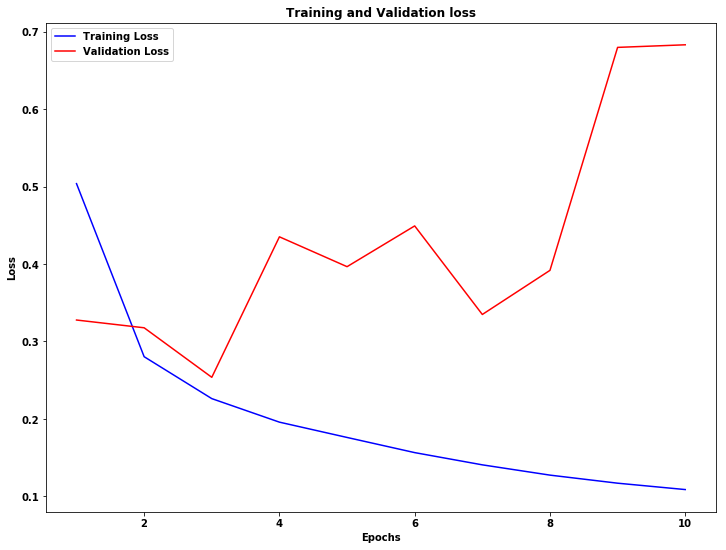

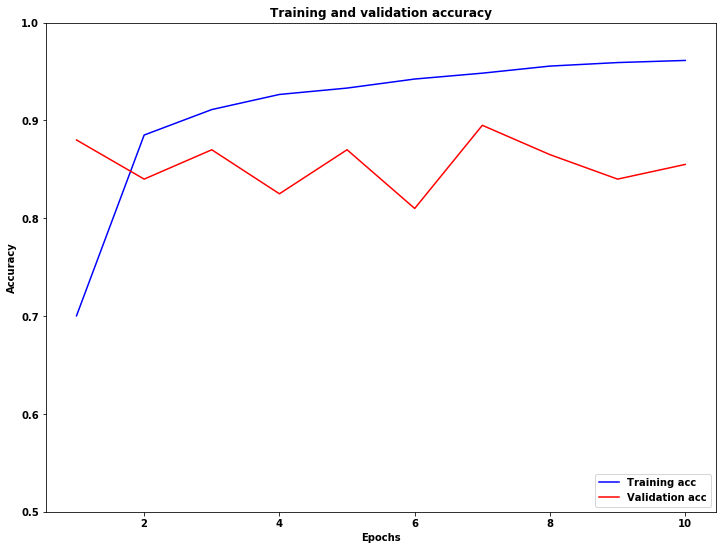

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

### Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (vocab_size, embedding-dimension).

In [18]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [21]:
import io

encoder = info.features["text"].encoder

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # Skip 0, it's padding
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in Colaboratory, you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).

In [22]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

#### Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector(http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

+ Click on "Load data".

+ Upload the two files we created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.